In [1]:
!pip install ta

In [2]:
print('🔄 Importing libraries...')
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from xgboost import XGBClassifier
import ta
import warnings
warnings.filterwarnings('ignore')
print('✅ Libraries imported.')

🔄 Importing libraries...
✅ Libraries imported.


In [10]:
print('📥 Downloading data...')
data = yf.download('^NSEI', start='2018-01-01', end='2024-12-31')
if data.empty:
    data = yf.download('NIFTYBEES.NS', start='2018-01-01', end='2024-12-31')
##Sometimes Yahoo returns a MULTIIndex (for ohlc data in tuples like (Close, NSEI))
#This line flattens column to a simple format.
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
print('✅ Data downloaded:', data.shape)

[*********************100%***********************]  1 of 1 completed

📥 Downloading data...
✅ Data downloaded: (1722, 5)


In [25]:
#save raw data
data.to_csv(r"C:\Users\shijin kunju\Desktop\ironhack\week9\final_project\Final_Project_StockPrediction\data\raw\nifty_raw.csv")
#save the cleaned data
data.to_csv(r"C:\Users\shijin kunju\Desktop\ironhack\week9\final_project\Final_Project_StockPrediction\data\clean\nifty_clean.csv")

In [11]:
##Generating techinical indicators to help the model understand stock behaviour.
print('⚙️ Creating technical indicators...')
data['rsi'] = ta.momentum.RSIIndicator(close=data['Close_^NSEI']).rsi()
data['ema'] = ta.trend.EMAIndicator(close=data['Close_^NSEI'], window=14).ema_indicator()
data['macd'] = ta.trend.MACD(close=data['Close_^NSEI']).macd()
data['return'] = data['Close_^NSEI'].pct_change()
data['vol_change'] = data['Volume_^NSEI'].pct_change()
data['bb_width'] = ta.volatility.BollingerBands(close=data['Close_^NSEI']).bollinger_wband()
data.dropna(inplace=True)
print('✅ Features ready:', data.shape)

⚙️ Creating technical indicators...
✅ Features ready: (1694, 11)


In [12]:
##creating target variable.labelling each day on whether the next days return is more than0.7%.
print('🎯 Creating target...')
data['Target'] = (data['Close_^NSEI'].pct_change().shift(-1) > 0.007).astype(int)
data.dropna(inplace=True)
print('✅ Target distribution:', data['Target'].value_counts().to_dict())

🎯 Creating target...
✅ Target distribution: {0: 1308, 1: 386}


In [13]:
#select feature columns and target
print('🧪 Splitting and balancing data...')
features = data[['rsi', 'ema', 'macd', 'return', 'vol_change', 'bb_width']]
labels = data['Target']
#Splits 80% training/ 20% test,shuffle=false keeps chonological order(important in time series)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(features, labels, test_size=0.2, shuffle=False)
#Seperates training data into buy vs hold classes.
train_df = pd.concat([X_train_orig, y_train_orig], axis=1)
minority = train_df[train_df['Target'] == 1]
majority = train_df[train_df['Target'] == 0]
#Upsamples the minority (buy) class to match the number of hold samples.
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
balanced_df = pd.concat([majority, minority_upsampled])
#Prepares balanced X_train and y_train for modelling.
X_train = balanced_df.drop(columns='Target')
y_train = balanced_df['Target']
print('✅ Data balanced. Train shape:', X_train.shape)

🧪 Splitting and balancing data...
✅ Data balanced. Train shape: (2050, 6)


In [18]:
print('🚀 Training XGBoost...')
#Replaces any infinite or missing values with nan.
#the drops rows and ensure all values are float.
X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna().astype(float)
X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna().astype(float)
#Ensures that the features and labels are perfectly aligned by index.
X_train = X_train.loc[X_train.index.intersection(y_train.index)]
y_train = y_train.loc[y_train.index.intersection(X_train.index)]
X_test = X_test.loc[X_test.index.intersection(y_test.index)]
y_test = y_test.loc[y_test.index.intersection(X_test.index)]
#Trains an XGboost classifier with tuned huperparameters.we use XGBoost because it handles tabular,imbalanced data well.
model = XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=4, scale_pos_weight=3, tree_method='hist')
model.fit(X_train, y_train)
#Gets the predicted probabilities for class 1(buy) and applies a custom threshold (0.40) to convert probabilities 1s and 0s.
#(insted of the default 0.5 cutoff, we lower the threshold to o.4 This increses the models sensitivity to detect buy signals)
probs = model.predict_proba(X_test)[:, 1]
threshold = 0.40
predictions = (probs > threshold).astype(int)
print('✅ Model trained and predictions made.')

🚀 Training XGBoost...
✅ Model trained and predictions made.


In [19]:
#Model eveluation
print('📊 Final Evaluation:')
acc = accuracy_score(y_test, predictions)
print(f'Accuracy: {acc * 100:.2f}%')
print(classification_report(y_test, predictions))


📊 Final Evaluation:
Accuracy: 72.54%
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       279
           1       0.25      0.32      0.28        56

    accuracy                           0.73       335
   macro avg       0.55      0.56      0.56       335
weighted avg       0.75      0.73      0.74       335



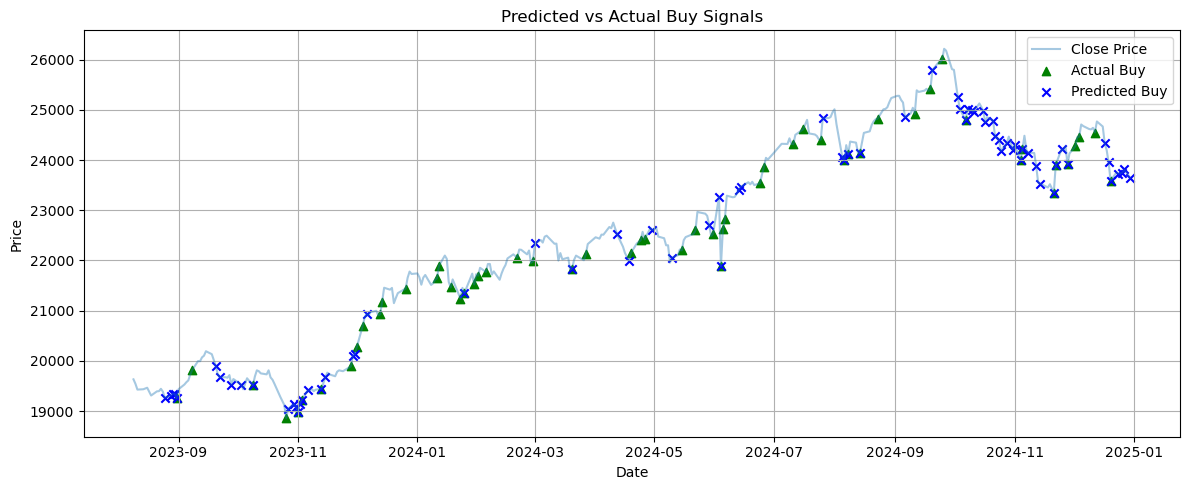

✅ Chart displayed.


In [20]:
#Plots actual close prices.
plt.figure(figsize=(12, 5))
plt.plot(data.loc[X_test.index]['Close_^NSEI'], label='Close Price', alpha=0.4)
plt.scatter(X_test[y_test == 1].index, data.loc[X_test[y_test == 1].index]['Close_^NSEI'], label='Actual Buy', color='green', marker='^')
plt.scatter(X_test[predictions == 1].index, data.loc[X_test[predictions == 1].index]['Close_^NSEI'], label='Predicted Buy', color='blue', marker='x')
plt.title('Predicted vs Actual Buy Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print('✅ Chart displayed.')